In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
import random as rn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential

**Read the data**

In [2]:
lookup = dict()
reverselookup = dict()
count=0
for j in os.listdir('leapGestRecog/00/'):
    if not j.startswith('.'): 
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'01_palm': 0,
 '02_l': 1,
 '03_fist': 2,
 '04_fist_moved': 3,
 '05_thumb': 4,
 '06_index': 5,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 8,
 '10_down': 9}

In [3]:
x_data = []
y_data = []

IMG_SIZE = 150
datacount = 0

for i in range(0, 10):
    for j in os.listdir('leapGestRecog/0' + str(i)):
        if not j.startswith('.'):  # Skip directories starting with a dot
            count = 0
            for k in os.listdir('leapGestRecog/0' + str(i) + '/' + j + '/'):
                path = 'leapGestRecog/0' + str(i) + '/' + j + '/' + k
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                arr = np.array(img)
                x_data.append(arr)
                count += 1
            
            y_values = np.full((count, 1), lookup[j])
            y_data.extend(y_values)
            datacount += count

x_data = np.array(x_data, dtype='float32')
y_data = np.array(y_data).reshape(datacount, 1)

In [4]:
%matplotlib inline  
from matplotlib import style
import seaborn as sns
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

**Visualize some photos in the dataset**

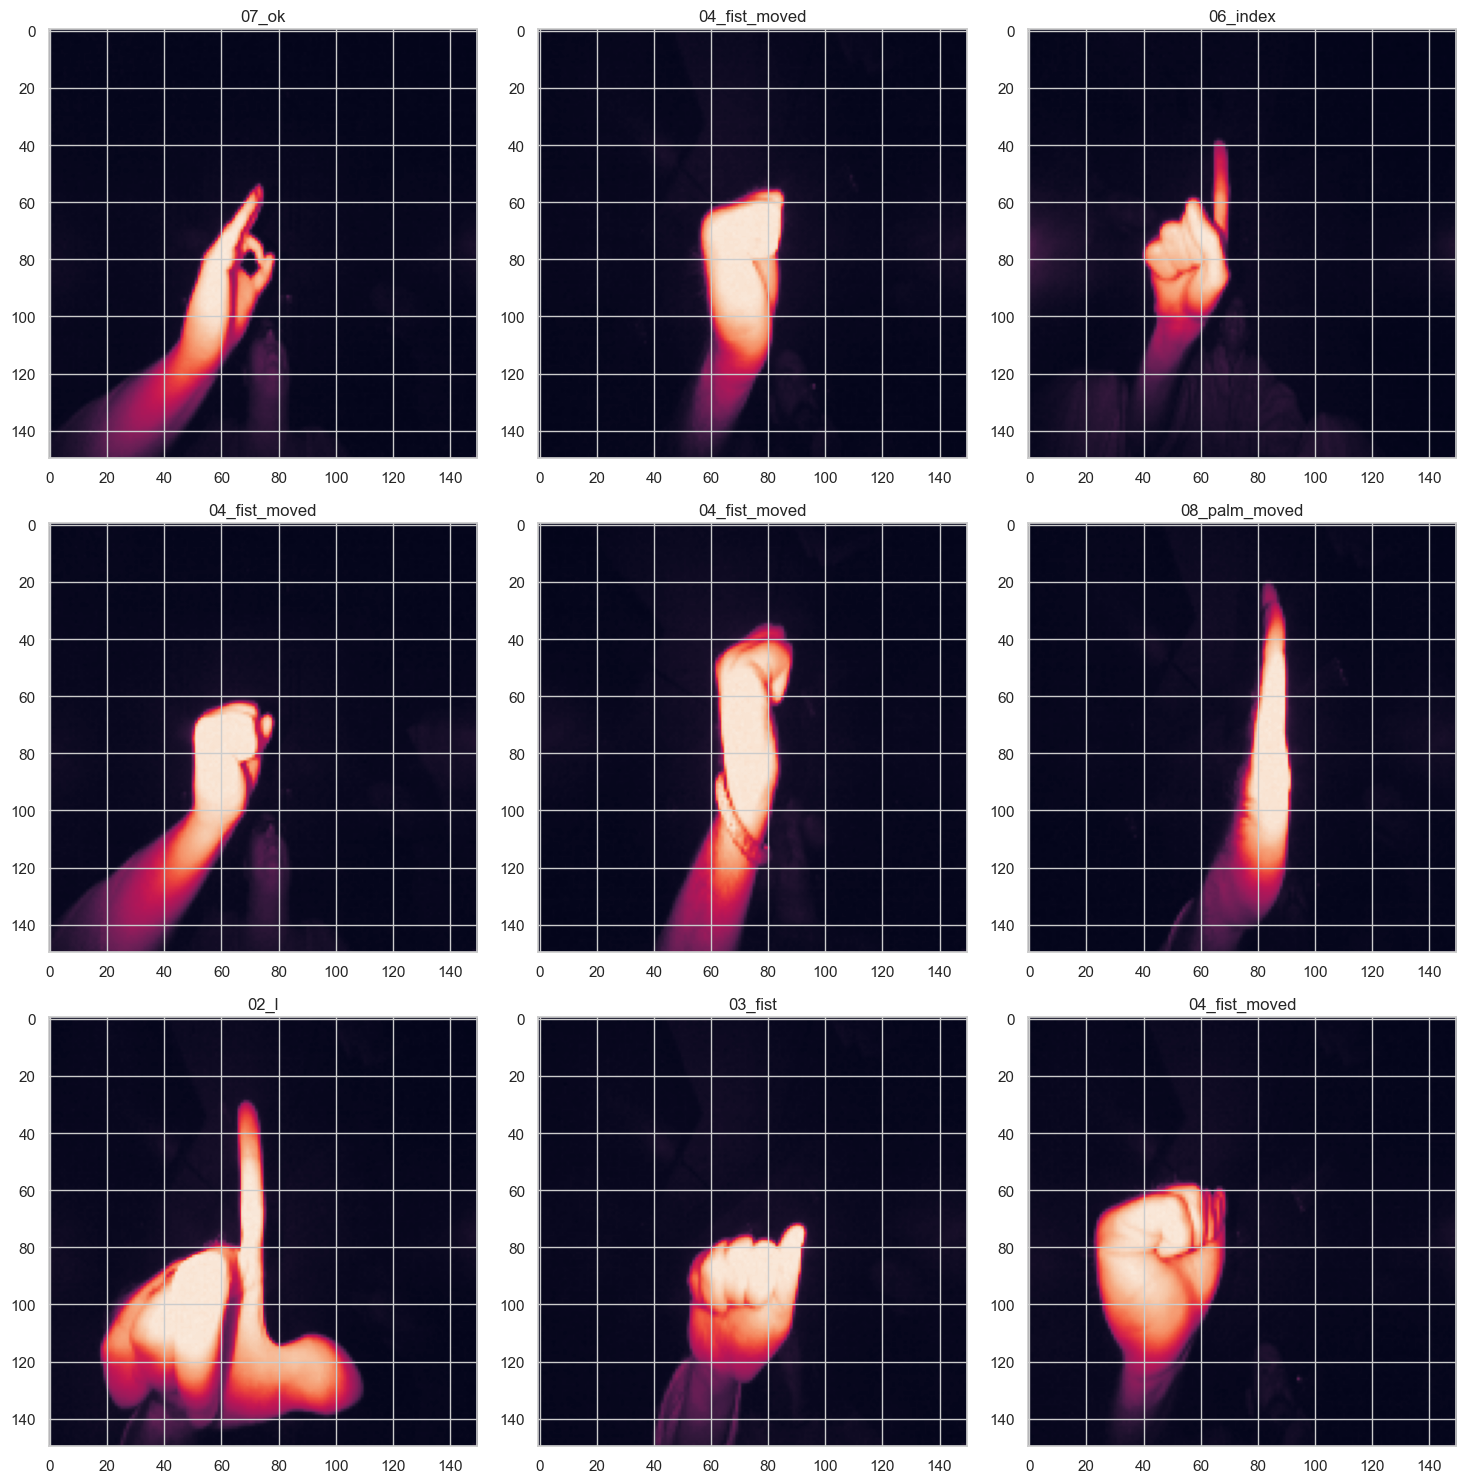

In [5]:
fig,ax=plt.subplots(3,3)
fig.set_size_inches(15,15)
for i in range(3):
    for j in range (3):
        l=rn.randint(0,len(y_data))
        ax[i,j].imshow(x_data[l])
        ax[i,j].set_title(reverselookup[y_data[l,0]])
        
plt.tight_layout()

**Split the dataset into train and test sets**

In [6]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [7]:
y_data=to_categorical(y_data)
x_data = x_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
x_data = x_data/255

In [8]:
x_train,x_val,y_train,y_val=train_test_split(x_data,y_data,test_size=0.2,random_state=42)

**Data augmentation**

In [9]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [12]:
# Create a training data generator
train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=100
)

In [13]:
# For validation data (no augmentation, since data is already rescaled)
validation_datagen = ImageDataGenerator()

# Create a validation data generator
validation_generator = validation_datagen.flow(
    x_val, y_val,
    batch_size=100
)

**Model Training**

In [14]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

Non-trainable params: 0
_________________________________________________________________


In [16]:
# checkpoint = ModelCheckpoint(
#     './base.model',
#     monitor='val_loss',
#     verbose=1,
#     save_best_only=True,
#     mode='min',
#     save_weights_only=False,
#     save_freq='epoch'  # Save every epoch
# )

# earlystop = EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.001,
#     patience=30,
#     verbose=1,
#     mode='auto'
# )

# tensorboard = TensorBoard(
#     log_dir='./logs',
#     histogram_freq=0,
#     write_graph=True,
#     write_images=False,
# )

# csvlogger = CSVLogger(
#     filename="training_csv.log",
#     separator=",",
#     append=False
# )

# reduce = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,
#     patience=3,
#     verbose=1,
#     mode='auto'
# )

# callbacks = [checkpoint, tensorboard, csvlogger, reduce]

In [17]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(
    train_generator,
    epochs=10,
    batch_size=128,
    validation_data=validation_generator
)

Epoch 1/10
160/160 [==============================] - 591s 4s/step - loss: 1.5805 - accuracy: 0.4209 - val_loss: 0.6775 - val_accuracy: 0.7262
Epoch 2/10
160/160 [==============================] - 564s 4s/step - loss: 0.5845 - accuracy: 0.7976 - val_loss: 0.1693 - val_accuracy: 0.9523
Epoch 3/10
160/160 [==============================] - 563s 4s/step - loss: 0.3511 - accuracy: 0.8832 - val_loss: 0.1191 - val_accuracy: 0.9720
Epoch 4/10
160/160 [==============================] - 535s 3s/step - loss: 0.2449 - accuracy: 0.9188 - val_loss: 0.0400 - val_accuracy: 0.9902
Epoch 5/10
160/160 [==============================] - 610s 4s/step - loss: 0.1777 - accuracy: 0.9416 - val_loss: 0.0265 - val_accuracy: 0.9950
Epoch 6/10
160/160 [==============================] - 515s 3s/step - loss: 0.1532 - accuracy: 0.9507 - val_loss: 0.0584 - val_accuracy: 0.9755
Epoch 7/10
160/160 [==============================] - 583s 4s/step - loss: 0.1286 - accuracy: 0.9591 - val_loss: 0.0121 - val_accuracy: 0.9975

In [19]:
#save the model
model.save('hand_gesture.h5')

**Live Test**

In [22]:
# Function to preprocess each frame
def preprocess_frame(frame, IMG_SIZE=IMG_SIZE):
    # Convert to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Resize to the same size as training data
    resized_frame = cv2.resize(gray_frame, (IMG_SIZE, IMG_SIZE))
    # Normalize the image data to 0-1 range as during training
    normalized_frame = resized_frame / 255.0
    # Reshape to fit the model input
    reshaped_frame = normalized_frame.reshape(1, IMG_SIZE, IMG_SIZE, 1)
    return reshaped_frame

In [23]:
# Initialize video capture
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        continue

    # Preprocess the captured frame
    preprocessed_frame = preprocess_frame(frame)

    # Make predictions
    prediction = model.predict(preprocessed_frame)
    gesture = np.argmax(prediction)

    # Display the predicted gesture
    cv2.putText(frame, reverselookup[gesture], (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    # Show the frame
    cv2.imshow('Live Test', frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 40ms/step
